# Exploring the UTx000 Extension EMA Data
(Known as BPEACE2 in the [GH repo](https://github.com/intelligent-environments-lab/utx000))

# Sleep Survey Data Restriction
Similar to restricting the data over periods when we have gps data, this notebook looks at the sleep surveys that we have received and restricts the beacon data to nights that preceded these surveys.

In [2]:
import warnings
warnings.filterwarnings('ignore')

## Package Import

In [3]:
import sys
sys.path.append('../')

from src.features import build_features
from src.visualization import visualize
from src.reports import make_report

import pandas as pd
import numpy as np
from beakerx import *
from beakerx.object import beakerx

from datetime import datetime, timedelta
import math

## Raw Data Check
Something looks iffy on the submission times for the surveys - checking some raw data.

In [13]:
temp = pd.read_csv('../data/raw/bpeace2/beiwe/survey_timing/zdpffrox/survey_timings/eQ2L3J08ChlsdSXXKOoOjyLJ/2020-06-03 14_00_00.csv')
temp

,timestamp,UTC time,question id,survey id,question type,question text,question answer options,answer,event
0,1591193984918,2020-06-03T14:19:44.918,NaN,eQ2L3J08ChlsdSXXKOoOjyLJ,NaN,NaN,NaN,NaN,notified


<div class="alert alert-block alert-danger">
THE TIMESTAMPS ARE IN UTC! Subtract five hours to get more appropriate values
</div>

## Data Import

### Morning Survey Data

In [6]:
sleep_survey = pd.read_csv('../data/processed/bpeace2-morning-survey.csv',
                           index_col=0,parse_dates=True,infer_datetime_format=True)
sleep_survey.head()

TypeError: 'NoneType' object is not callable

### Evening Survey Data

In [5]:
evening_survey = pd.read_csv('../data/processed/bpeace2-evening-survey.csv',
                             index_col=0,parse_dates=True,infer_datetime_format=True)
evening_survey.head()

,ID,Content,Stress,Lonely,Sad,Energy
2020-08-14 22:34:30,hfttkth7,1.0,1,1.0,2,2
2020-08-21 20:13:33,hfttkth7,1.0,1,1.0,2,2
2020-08-08 15:28:21,hfttkth7,1.0,1,1.0,1,0
2020-08-19 22:49:14,hfttkth7,1.0,1,1.0,1,2
2020-07-21 08:44:00,hfttkth7,1.0,0,1.0,2,0


### Weekly Survey Data

<div class='alert-block alert-danger'>
    Currently no weekly data being imported
</div>

In [6]:
#evening_survey = pd.read_csv('../data/processed/bpeace2-.csv',index_col=0,parse_dates=True)
#evening_survey.head()

# Analyzing the Morning Survey Data
Taking a closer look at what data are available for morning/sleep surveys.

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

In [8]:
def label_hist(n, bins, ax):
    '''
    Labels the histogram with values above the bars
    
    Inputs:
    - n: the counts for each bin
    - bins: the actual bins limits
    
    Returns void
    '''
    k = []
    # calculate the relative frequency of each bin
    for i in range(0,len(n)):
        k.append(round((bins[i+1]-bins[i])*n[i],0))

    # plot the label/text to each bin
    for i in range(0, len(n)):
        x_pos = bins[i] + (bins[i+1] - bins[i]) / 2
        y_pos = n[i]
        label = str(k[i])[:-2] # relative frequency of each bin
        ax.text(x_pos, y_pos, label, ha='center', va='bottom')

## Mood
Mood questions are those that ask about the participants contentment, stress, loneliness, sadness, and energy levels.

### Histogram

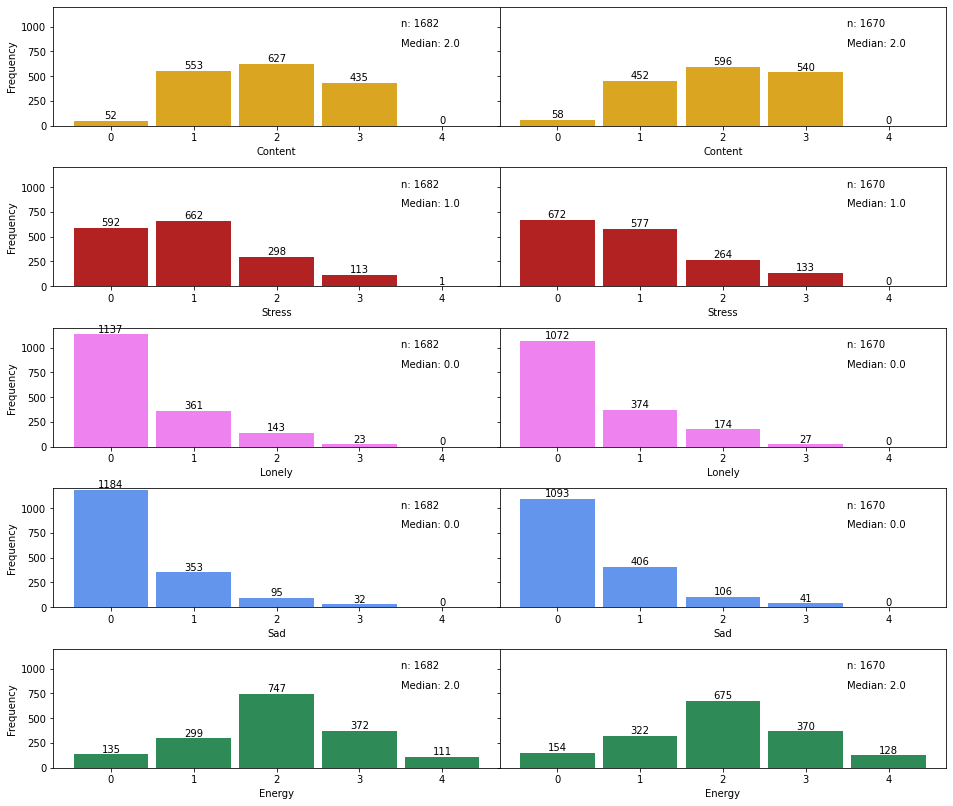

In [9]:
fig, axes = plt.subplots(5,2,figsize=(16,14),sharey='row')
c = 0
for df in [sleep_survey,evening_survey]:
    r = 0
    for question, color in zip(['Content','Stress','Lonely','Sad','Energy'],['goldenrod','firebrick','violet','cornflowerblue','seagreen']):
        ax = axes[r,c]
        n,bins,patches = ax.hist(df[question],bins=[-0.5,0.5,1.5,2.5,3.5,4.5],rwidth=0.9,color=color)
        ax.set_xlabel(question)
        if c == 0:
            ax.set_ylabel('Frequency')
        ax.set_ylim([0,1200])

        ax.text(3.5,1000,f'n: {len(df[question])}')
        ax.text(3.5,800,f'Median: {np.nanmedian(df[question])}')

        label_hist(n, bins, ax)
        
        r += 1
        
    c += 1

plt.subplots_adjust(wspace=0,hspace=0.35)
plt.show()
plt.close()

## Sleep
Sleep portions of the survey includes:
- TST: total sleep time
- SOL: sleep onset latency
- NAW: number of awakenings
- Restful: Likert scale 0-3

In [10]:
import scipy.stats as st

### Aggregate Histogram
Plotting the EMA survey results.

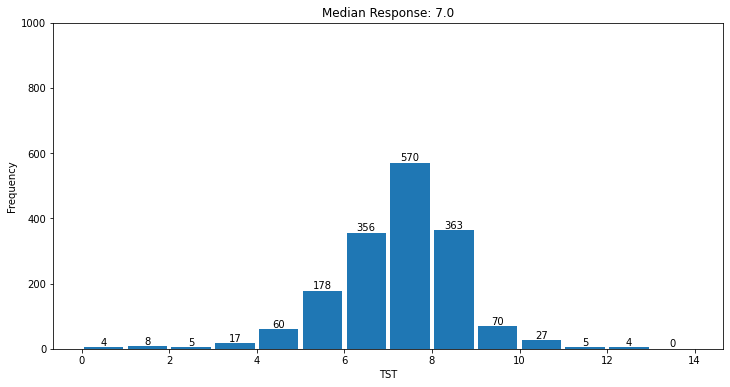

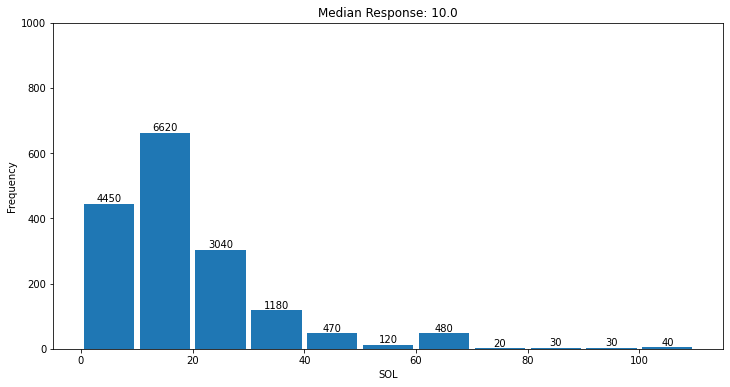

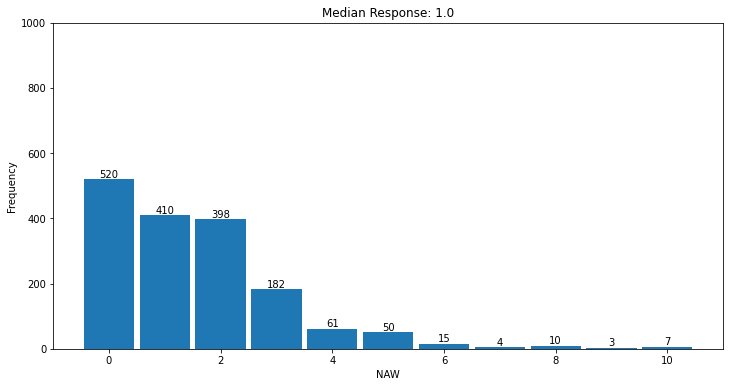

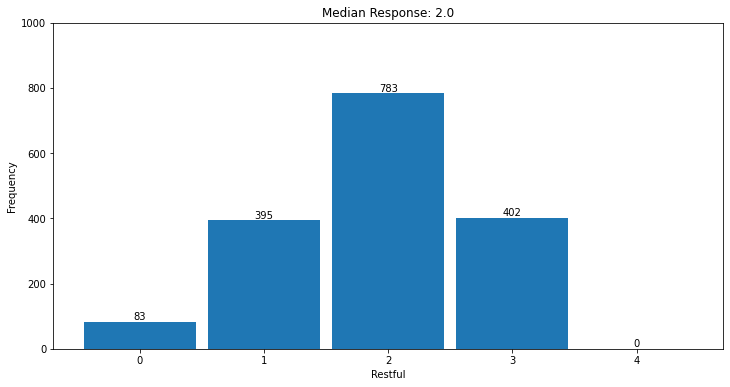

In [11]:
questions = ['TST','SOL','NAW','Restful']
bin_list = [np.arange(0,15,1),
           np.arange(0,120,10),
           np.arange(-0.5,11.5,1),
           [-0.5,0.5,1.5,2.5,3.5,4.5]]

for question, bins in zip(questions, bin_list):
    fig, ax = plt.subplots(figsize=(12,6))
    n,bins,patches = plt.hist(sleep_survey[question],bins=bins,rwidth=0.9,align='mid')
    ax.set_xlabel(question)
    ax.set_ylabel('Frequency')
    ax.set_ylim([0,1000])
    
    ax.set_title(f'Median Response: {np.nanmedian(sleep_survey[question])}')
    
    label_hist(n, bins, ax)
        
    plt.show()
    plt.close()

### Per Participant Responses

In [12]:
first_date = datetime(2020,6,10) # beiwe surveys were fixed this day
end_date = datetime(2020,9,1) # this was the first sampling appointment - some pts might have turned off beiwe
maxDailySurveys = np.busday_count(first_date.date(), end_date.date(), weekmask='Sun Mon Wed Fri')
print(f'Maximum \"Daily\" Surveys: {maxDailySurveys}')
maxWeeklySurveys = np.busday_count(first_date.date(), end_date.date(), weekmask='Sat')
print(f'Maximum Weekly Surveys: {maxWeeklySurveys}')

Maximum "Daily" Surveys: 48
Maximum Weekly Surveys: 12


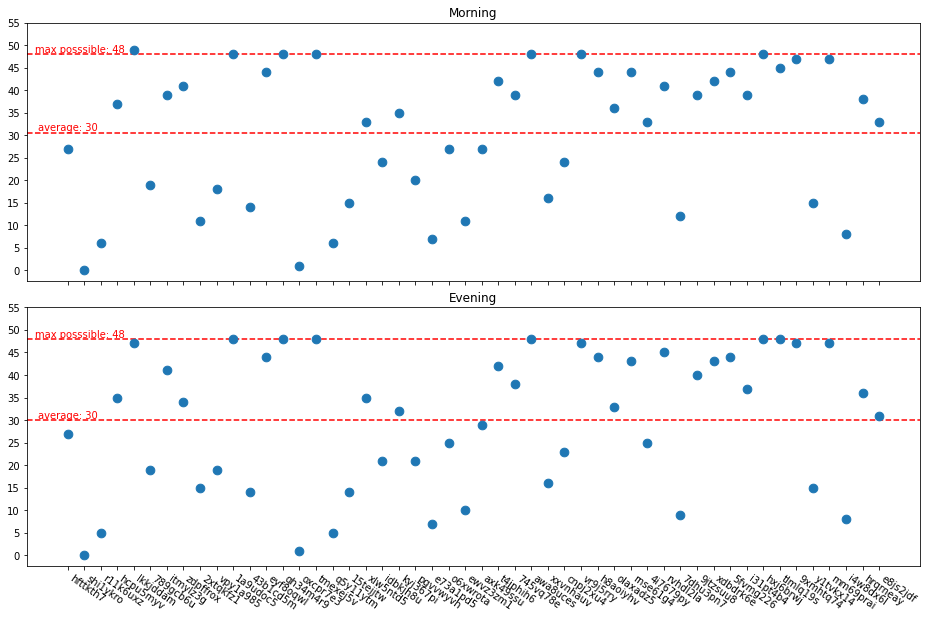

In [13]:
fig, axes = plt.subplots(2,1,figsize=(16,10),sharex='col')
i = 0
for df in [sleep_survey,evening_survey]:
    # Number of surveys submitted
    bid = []
    surveys_submitted = []
    # Looping through beacon participants only
    for beiwe in df['ID'].unique():
        survey_by_beiwe = df[df['ID'] == beiwe]
        survey_by_beiwe = survey_by_beiwe[(survey_by_beiwe.index >= first_date) &
         (survey_by_beiwe.index <= end_date)]
        bid.append(beiwe)
        surveys_submitted.append(len(survey_by_beiwe))

    ax = axes[i]
    # scattering number of surveys submitted per participant
    ax.scatter(bid,surveys_submitted,s=75,zorder=10)

    ax.set_yticks(np.arange(0,60,5))
    plt.xticks(rotation=-35,ha='left')
    # adding average line
    ax.axhline(np.nanmean(surveys_submitted),color='red',linestyle='dashed')
    avg = int(np.nanmean(surveys_submitted))
    ax.text(bid[0],np.nanmean(surveys_submitted),f'average: {avg}',va='bottom',ha='center',color='red')
    #percentage
    ax.axhline(maxDailySurveys,color='red',linestyle='dashed')
    ax.text(bid[0],maxDailySurveys,f'        max posssible: {maxDailySurveys}',va='bottom',ha='center',color='red')
    
    if i == 0:
        ax.set_title('Morning')
    else:
        ax.set_title('Evening')
    
    i+= 1
    
plt.subplots_adjust(hspace=0.1)
plt.savefig('../reports/utx000_initial_update/figures/beiwe-beiwe-number-weekly-surveys.pdf')
plt.show()
plt.close()

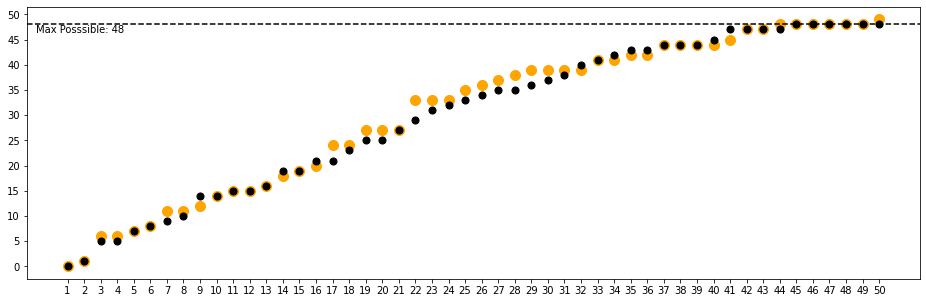

In [14]:
fig, ax = plt.subplots(figsize=(16,5))
temp_dict = dict({})
i = 0
for df, color, size in zip([sleep_survey,evening_survey],['orange','black'],[100,50]):
    # Number of surveys submitted
    bid = []
    surveys_submitted = []
    # Looping through beacon participants only
    for beiwe in df['ID'].unique():
        survey_by_beiwe = df[df['ID'] == beiwe]
        survey_by_beiwe = survey_by_beiwe[(survey_by_beiwe.index >= first_date) &
         (survey_by_beiwe.index <= end_date)]
        bid.append(beiwe)
        surveys_submitted.append(len(survey_by_beiwe))
    temp_dict[f'pts{i}'] = bid
    temp_dict[color] = surveys_submitted
    surveys_submitted.sort()

    # scattering number of surveys submitted per participant
    ax.scatter(bid,surveys_submitted,s=size,color=color)

    ax.set_yticks(np.arange(0,55,5))
    i += 1
    
ax.set_xticklabels(pd.DataFrame(temp_dict).index+1)
#percentage
ax.axhline(maxDailySurveys,color='black',linestyle='dashed')
ax.text(bid[0],maxDailySurveys,f'        Max Posssible: {maxDailySurveys}',va='top',ha='center',color='black')
    
plt.subplots_adjust(hspace=0.1)
plt.savefig('../reports/conferences/BuildSys_2020/beiwe-beiwe-number-weekly-surveys-ordered.pdf')
plt.show()
plt.close()

In [15]:
submission = pd.DataFrame(temp_dict)
submission['orange_pct'] = submission['orange'] / maxDailySurveys * 100
submission['black_pct'] = submission['black'] / maxDailySurveys * 100
cutoffs = pd.DataFrame()
for color in ['orange','black']:
    cutoff_dict = dict({})
    for cutoff in [0,25,50,75,85,95]:
        temp = submission[submission[f'{color}_pct'] >= cutoff]
        cutoff_dict[cutoff] = [len(temp)]

    cutoffs_survey = pd.DataFrame(cutoff_dict)
    cutoffs = cutoffs.append(cutoffs_survey)
    
cutoffs

,0,25,50,75,85,95
0,50,42,34,25,18,9
0,50,42,32,22,18,10


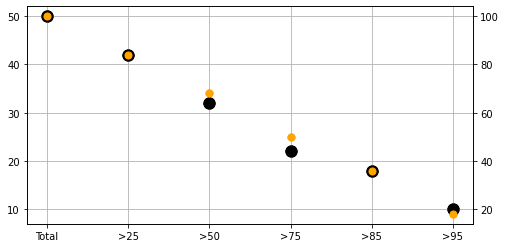

In [16]:
fig, ax = plt.subplots(figsize=(8,4))
for i, size, color in zip([1,0],[125,50],['black','orange']):
    ax.scatter(np.arange(6),cutoffs.iloc[i,:],color=color,s=size)


ax.set_xticks(np.arange(6))
ax.set_xticklabels(['Total','>25','>50','>75','>85','>95'])
#ax.set_ylim([0,60])

ax2 = ax.twinx()
for i, size, color in zip([1,0],[125,50],['black','orange']):
    ax2.scatter(np.arange(6),cutoffs.iloc[i,:]/50*100,color=color,s=size)
    
#ax2.set_ylim([0,100])
ax.grid('both',zorder=1)
   
plt.savefig(f'../reports/conferences/BuildSys_2020/beiwe-beiwe-survey-completeness-combined.pdf')
plt.show()
plt.close()

### Differences in the Day of the Week


Restricted to Beacon Participants Only: False


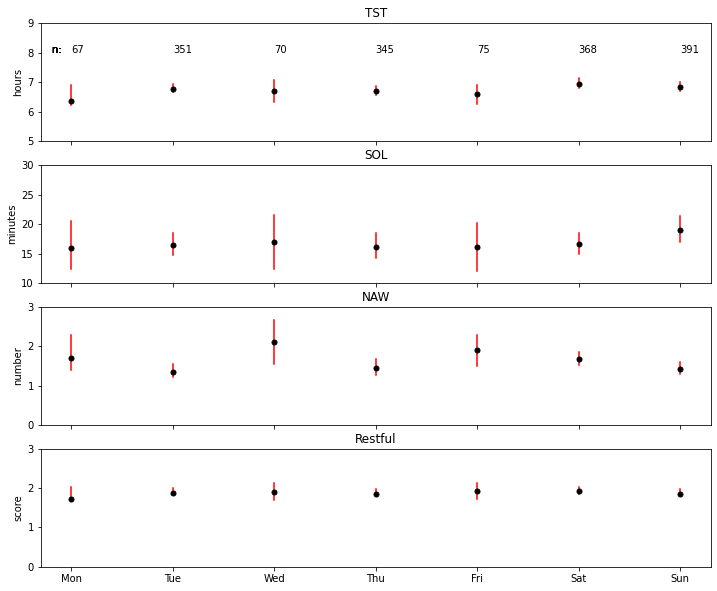

Restricted to Beacon Participants Only: True


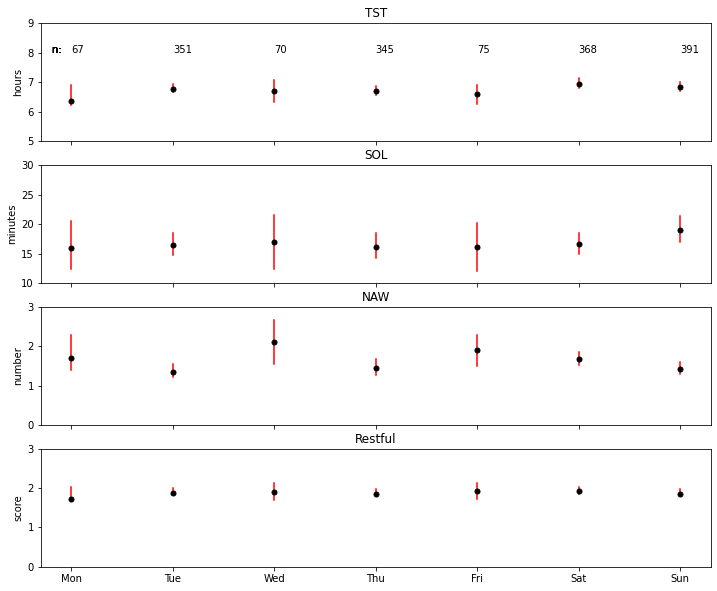

In [17]:
# grouping by night sleep (survey date - 1 day)
sleep_survey['DoW'] = (sleep_survey.index - timedelta(days=1)).strftime('%a')
# all participants
sleep_survey_dow = sleep_survey.groupby(['DoW']).mean()
sleep_survey_dow = sleep_survey_dow.reindex(["Mon", "Tue", "Wed","Thu","Fri","Sat",'Sun'])
# beacon-holding participants only
sleep_survey_restricted = sleep_survey[sleep_survey['ID'].isin(bid)]
sleep_survey_dow_beacon = sleep_survey_restricted.groupby(['DoW']).mean()
sleep_survey_dow_beacon = sleep_survey_dow_beacon.reindex(["Mon", "Tue", "Wed","Thu","Fri","Sat",'Sun'])
# looping through both dataframes
for df, restricted in zip([sleep_survey_dow,sleep_survey_dow_beacon],[False,True]):
    print(f'Restricted to Beacon Participants Only: {restricted}')
    fig, axes = plt.subplots(4,1,figsize=(12,10),sharex=True)
    i=0
    limits = [[5,9],[10,30],[0,3],[0,3]]
    for question, limit, ylabel in zip(['TST','SOL','NAW','Restful'],limits,['hours','minutes','number','score']):

        sleep_survey_dow_plot = df[df[question] >= 0]
        # Scattering for day of week
        axes[i].scatter(sleep_survey_dow_plot.index,sleep_survey_dow_plot[question],s=25,color='black',zorder=10)
        axes[i].set_title(question)
        axes[i].set_ylim(limit)
        axes[i].set_ylabel(ylabel)

        # Adding 95% CI
        for day in sleep_survey['DoW'].unique():
            sleep_survey_by_day = sleep_survey[sleep_survey['DoW'] == day]
            if restricted:
                sleep_survey_by_day = sleep_survey_by_day[sleep_survey_by_day['ID'].isin(bid)]

            sleep_survey_by_day = sleep_survey_by_day[sleep_survey_by_day[question] >= 0]
            ci = st.t.interval(0.95, len(sleep_survey_by_day[question])-1,
                          loc=np.mean(sleep_survey_by_day[question]),
                          scale=st.sem(sleep_survey_by_day[question]))

            axes[i].plot([day,day],ci,color='red',zorder=1) 
            # adding number of surveys on top figure
            if question == 'TST':
                axes[i].text('Mon',8,'n:   ',ha='right')
                axes[i].text(day,8,len(sleep_survey_by_day))
        i += 1

    plt.subplots_adjust(wspace=0,hspace=0.2)
    plt.show()
    plt.close()

### Per Participant Responses

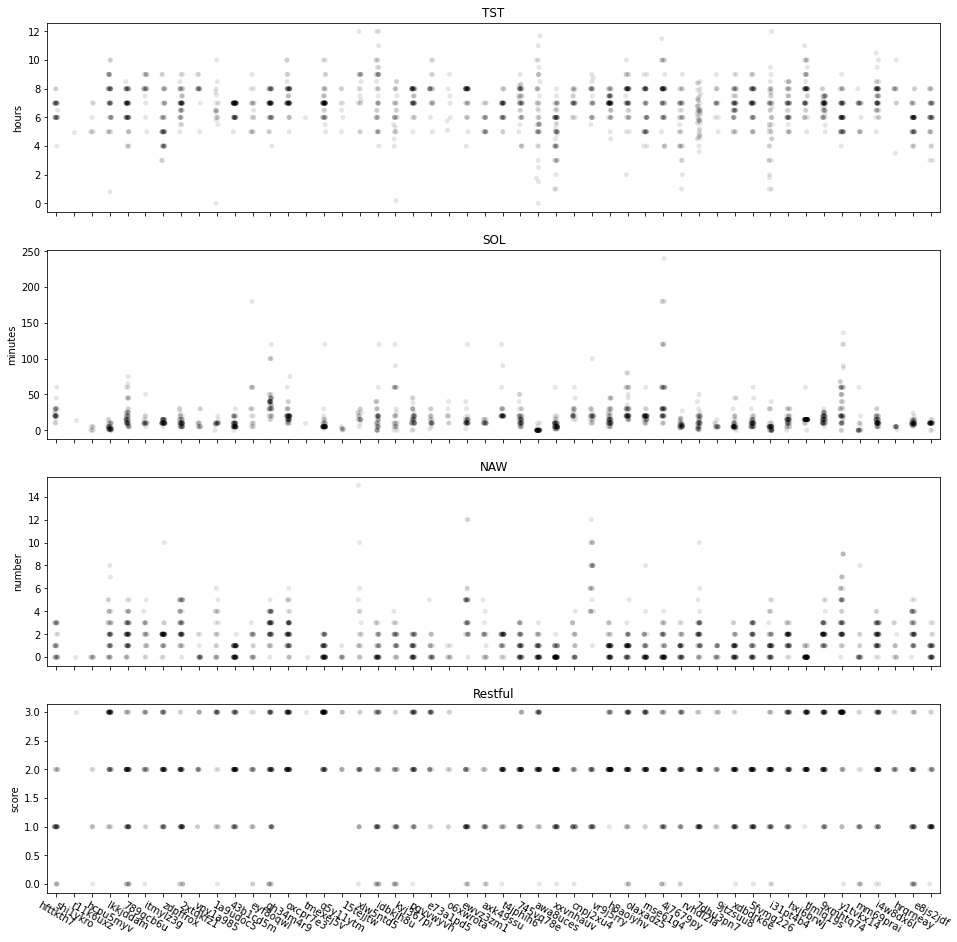

In [18]:
# Sleep metrics
fig, axes = plt.subplots(4,1,figsize=(16,16),sharex=True)
sleep_survey_restricted = sleep_survey[sleep_survey['ID'].isin(bid)]
i = 0
for question, ylabel in zip(['TST','SOL','NAW','Restful'],['hours','minutes','number','score']):
    sleep_survey_restricted_plot = sleep_survey_restricted[sleep_survey_restricted[question] >= 0]
    sns.stripplot(x='ID',y=question,data=sleep_survey_restricted_plot,color='black',alpha=0.1,ax=axes[i])
    axes[i].set_xlabel('')
    axes[i].set_ylabel(ylabel)
    axes[i].set_title(question)
    
    i += 1
    
plt.xticks(rotation=-30)
plt.subplots_adjust(hspace=0.2)
plt.show()
plt.close()

# Analysis on Fully Filtered Dataset
In the following cells, we only consider the data from the fully filtered dataset - that is data from nights when we have GPS confirming pts are home, Fitbit data confirming pts are asleep, and beacon data from their environment.

## Pre-Processing
We have the nights we need to consider, so first we have to filter the overall EMA dataframe by the nights present in the fully filtered beacon data.

In [19]:
ff_df = pd.read_csv('../data/processed/bpeace2-beacon-fb_ema_and_gps_restricted.csv',
                                 index_col=0, parse_dates=[0,-2,-1], infer_datetime_format=True)

Adding date columns to eventually merge on

In [20]:
ff_df['date'] = ff_df['end_time'].dt.date
sleep_survey['date'] = sleep_survey.index.date

Merging the two dataframes to get the correct number of nights.

In [21]:
ff_sleep_survey_df = pd.DataFrame() # dataframe to hold the relevant sleep EMAs
# looping through fully filtered data and merging dataframes on common start times
for pt in ff_df['Beiwe'].unique():
    ff_sleep_pt = sleep_survey[sleep_survey['ID'] == pt]
    ff_pt = ff_df[ff_df['Beiwe'] == pt]
    ff_pt_summary = ff_pt.groupby('date').mean()
    
    ff_sleep_survey_df = ff_sleep_survey_df.append(pd.merge(left=ff_sleep_pt,right=ff_pt_summary,left_on='date',right_on='date',how='inner'))

print('Number of nights with EMAs completed:', len(ff_sleep_survey_df))

Number of nights with EMAs completed: 178


In [22]:
ff_sleep_survey_df.head()

,ID,Content,Stress,Lonely,Sad,Energy,TST,SOL,NAW,Restful,...,PM_N_2p5,PM_N_4,PM_N_10,PM_C_1,PM_C_2p5,PM_C_4,PM_C_10,Beacon,Fitbit,REDCap
0,lkkjddam,1.0,1.0,0.0,1.0,1.0,6.0,20.0,2.0,1.0,...,12.628237,13.446407,13.611750,1.619614,6.297964,10.008931,10.751125,21,25,12
1,lkkjddam,1.0,2.0,0.0,3.0,1.0,7.0,10.0,3.0,1.0,...,15.490433,16.412822,16.599408,1.982984,7.264487,11.446701,12.283143,21,25,12
2,lkkjddam,1.0,1.0,0.0,1.0,2.0,6.0,5.0,0.0,1.0,...,15.162251,16.067154,16.250199,1.941066,7.122249,11.225221,12.045815,21,25,12
3,lkkjddam,1.0,2.0,1.0,2.0,1.0,6.0,20.0,4.0,1.0,...,13.030803,13.880528,14.052236,1.671495,6.529800,10.383996,11.154836,21,25,12
4,lkkjddam,1.0,2.0,1.0,1.0,1.0,6.0,25.0,2.0,1.0,...,16.283555,17.199481,17.384891,2.082057,7.331746,11.483604,12.313976,21,25,12


<div class="alert alert-block alert-warning">
    Somehow we currently have one extra day (178 vs 177) than we should.
</div>

## Summary
The following cells highlight some summary information and illustrate it with figures.

In [23]:
def plot_stacked_hist(df,var,limits,width=1,cmap='coolwarm',by_var='beiwe',save=False,save_dir='../reports/figures/'):
    '''
    Plots a stacked histogram with each color representing a unique individual.
    
    Inputs:
    - df: dataframe of the data
    - var: string specifying the column in the dataframe to plot
    - limits: tuple representing the lower and upper bound on the x-axis
    - width: integer/float for the width of each bin
    - by_var: string specifying the column to color the stacks by
    - save: boolean to save or not
    - save_dr: string representing the location to save the figure if save is True
    
    Returns the axes with the histogram
    '''
    list_to_plot = []
    for pt in df[by_var].unique():
        temp_df = df[df[by_var] == pt]
        list_to_plot.append(temp_df[var].to_list())
    
    colors = cm.get_cmap(cmap, len(list_to_plot))
    fig, ax = plt.subplots(figsize=(8,4))
    n, bins, _ = ax.hist(list_to_plot,bins=np.arange(limits[0],limits[1]+width,width),stacked=True,rwidth=0.9,
            color=colors(np.linspace(0, 1, len(list_to_plot))),edgecolor='black')
    
    for loc in ['right','top']:
        ax.spines[loc].set_visible(False)
    ax.set_ylabel('Count')

    if save == True:
        plt.savefig(f'{save_dir}/bpeace2-{var}-stacked_hist.pdf')
        
    return ax
    

### TST

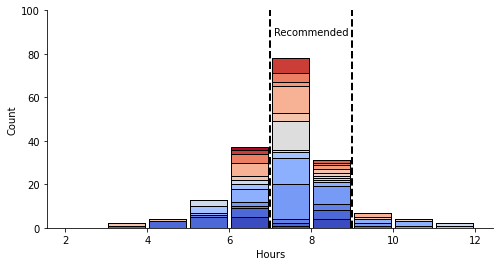

In [24]:
ax = plot_stacked_hist(ff_sleep_survey_df,'TST',[2,12],by_var='ID')
ax.set_ylim([0,100])
ax.set_xlabel('Hours')

ax.axvline(7,color='black',linestyle='dashed',linewidth=2)
ax.axvline(9,color='black',linestyle='dashed',linewidth=2)
ax.text(8,90,"Recommended",ha='center',va='center')

plt.savefig('../reports/figures/bpeace2-beiwe_sleep_duration-stacked_hist.pdf')
plt.show()
plt.close()

In [25]:
p_7to9 = len(ff_sleep_survey_df[(ff_sleep_survey_df['TST'] >= 7) & (ff_sleep_survey_df['TST'] <= 9)])/len(ff_sleep_survey_df['TST'])
print('Number of nights between 7 and 9 hours of sleep:\t', p_7to9*100)

p_6to7 = len(ff_sleep_survey_df[(ff_sleep_survey_df['TST'] >= 6) & (ff_sleep_survey_df['TST'] < 7)])/len(ff_sleep_survey_df['TST'])
print('Number of nights between 6 and 7 hours of sleep:\t', p_6to7*100)

p_gt_7 = len(ff_sleep_survey_df[(ff_sleep_survey_df['TST'] >= 7)])/len(ff_sleep_survey_df['TST'])
print('Number of nights greater than 7 hours of sleep:\t\t', p_gt_7*100)

p_gt_9 = len(ff_sleep_survey_df[(ff_sleep_survey_df['TST'] > 9)])/len(ff_sleep_survey_df['TST'])
print('Number of nights greater than 9 hours of sleep:\t\t', p_gt_9*100)

p_lt_7 = len(ff_sleep_survey_df[(ff_sleep_survey_df['TST'] < 7)])/len(ff_sleep_survey_df['TST'])
print('Number of nights less than 7 hours of sleep:\t\t', p_lt_7*100)

Number of nights between 7 and 9 hours of sleep:	 65.1685393258427
Number of nights between 6 and 7 hours of sleep:	 20.786516853932586
Number of nights greater than 7 hours of sleep:		 68.53932584269663
Number of nights greater than 9 hours of sleep:		 3.3707865168539324
Number of nights less than 7 hours of sleep:		 31.46067415730337


Looking at the reported TSTs to see how participants tend to report TST.

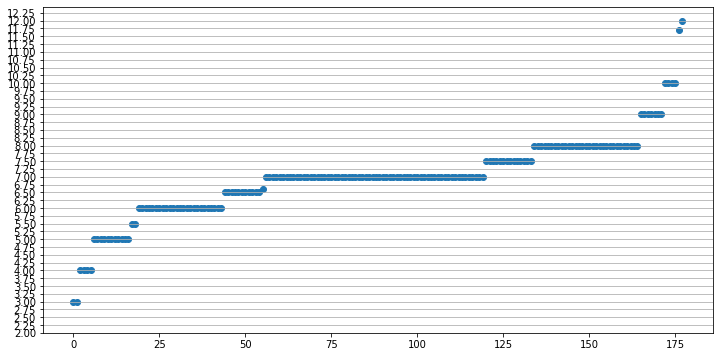

In [26]:
fig, ax = plt.subplots(figsize=(12,6))
ff_sleep_survey_df.sort_values(['TST'],inplace=True)
ax. scatter(np.arange(0,len(ff_sleep_survey_df)), ff_sleep_survey_df['TST'])
ax.set_yticks(np.arange(2,12.5,0.25))
ax.grid(axis='y')

plt.show()
plt.close()

<div class="alert alert-block alert-success">
    Participants tend to report their TST at half-hour increments with two exceptions.
</div>

### SOL
We have SOL reported by the pts.

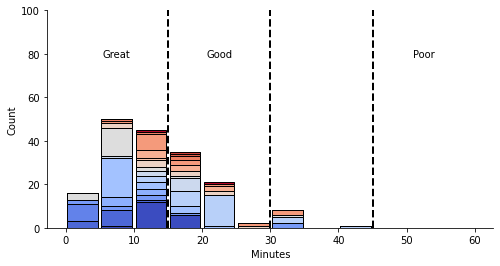

In [27]:
ax = plot_stacked_hist(ff_sleep_survey_df,'SOL',[0,60],width=5,by_var='ID')
ax.set_ylim([0,100])
ax.set_xlabel('Minutes')

ax.axvline(15,color='black',linestyle='dashed',linewidth=2)
ax.axvline(30,color='black',linestyle='dashed',linewidth=2)
ax.axvline(45,color='black',linestyle='dashed',linewidth=2)
ax.text(7.5,80,"Great",ha='center',va='center')
ax.text(22.5,80,"Good",ha='center',va='center')
ax.text(52.5,80,"Poor",ha='center',va='center')

plt.savefig('../reports/figures/bpeace2-beiwe_sleep_sol-stacked_hist.pdf')
plt.show()
plt.close()

In [28]:
cutoffs = [15,30,50]
for cutoff in cutoffs:
    p_lt_cutoff = ff_sleep_survey_df[ff_sleep_survey_df['SOL'] < cutoff]
    print(f'Percent of SOL less than {cutoff} minutes:', round(len(p_lt_cutoff)/len(ff_sleep_survey_df)*100,1))

Percent of SOL less than 15 minutes: 62.4
Percent of SOL less than 30 minutes: 94.9
Percent of SOL less than 50 minutes: 100.0


In [29]:
high_sol = ff_sleep_survey_df[ff_sleep_survey_df['SOL'] >= 30]
high_sol

,ID,Content,Stress,Lonely,Sad,Energy,TST,SOL,NAW,Restful,...,PM_N_2p5,PM_N_4,PM_N_10,PM_C_1,PM_C_2p5,PM_C_4,PM_C_10,Beacon,Fitbit,REDCap
11,vr9j5rry,2.0,0.0,0.0,0.0,4.0,7.0,30.0,2.0,3.0,...,31.442059,32.251977,32.402239,3.977153,8.811549,12.539168,13.284692,25,36,34
8,xlw5ntd5,1.0,0.0,0.0,0.0,0.0,7.0,30.0,2.0,3.0,...,29.486814,30.369533,30.562668,3.728705,8.123860,11.507547,12.184284,10,41,43
0,vr9j5rry,2.0,1.0,0.0,0.0,3.0,7.0,30.0,1.0,2.0,...,20.836033,21.639456,21.787376,2.648023,7.382024,11.090203,11.831839,25,36,34
13,qh34m4r9,3.0,0.0,0.0,0.0,3.0,7.0,30.0,2.0,2.0,...,13.724008,14.533917,14.691310,1.751310,5.748163,8.901455,9.532114,19,16,68
12,qh34m4r9,3.0,0.0,0.0,0.0,3.0,7.0,30.0,4.0,2.0,...,13.409631,14.218313,14.375450,1.711873,5.700829,8.849564,9.479312,19,16,68
24,qh34m4r9,3.0,1.0,0.0,0.0,2.0,7.0,40.0,0.0,3.0,...,16.735496,17.567548,17.729396,2.129496,6.252126,9.489623,10.137124,19,16,68
26,qh34m4r9,3.0,1.0,0.0,0.0,3.0,7.0,30.0,6.0,3.0,...,20.557188,21.510252,21.695720,2.613075,7.343986,11.051287,11.658996,19,16,68
5,9jtzsuu8,2.0,0.0,0.0,0.0,2.0,9.0,30.0,1.0,2.0,...,26.243694,27.342472,27.556259,3.339617,9.836216,14.938742,15.959246,15,37,36
1,xlw5ntd5,3.0,1.0,1.0,0.0,2.0,12.0,30.0,0.0,3.0,...,11.480050,12.250001,12.416539,1.468271,5.218892,8.186065,8.779500,10,41,43


###  Awakenings

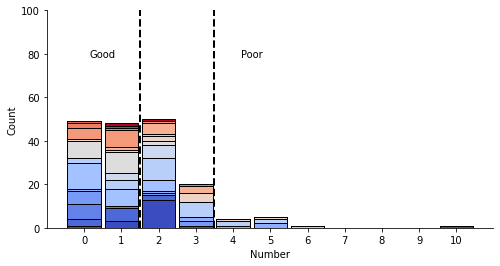

In [30]:
ax = plot_stacked_hist(ff_sleep_survey_df,'NAW',[0,11],width=1,by_var='ID')
ax.set_ylim([0,100])
ax.set_xlabel('Number')

# resetting xtick-labels
ax.set_xticks(np.arange(0.5,11.5,1))
ax.set_xticklabels(np.arange(0,11,1))

ax.axvline(2,color='black',linestyle='dashed',linewidth=2)
ax.axvline(4,color='black',linestyle='dashed',linewidth=2)
ax.text(1,80,"Good",ha='center',va='center')
ax.text(5,80,"Poor",ha='center',va='center')

plt.savefig('../reports/figures/bpeace2-beiwe_sleep_awakenings-stacked_hist.pdf')
plt.show()
plt.close()

In [31]:
cutoffs = [2,4]
for cutoff in cutoffs:
    p_lt_cutoff = ff_sleep_survey_df[ff_sleep_survey_df['NAW'] < cutoff]
    print(f'Percent of NAW less than {cutoff}:', round(len(p_lt_cutoff)/len(ff_sleep_survey_df)*100,1))

Percent of NAW less than 2: 54.5
Percent of NAW less than 4: 93.8


### Restful Score
On a scale of 0-3 (not at all to very much)

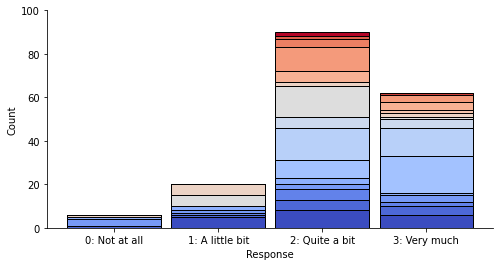

In [32]:
ax = plot_stacked_hist(ff_sleep_survey_df,'Restful',[0,4],width=1,by_var='ID')
ax.set_ylim([0,100])
ax.set_xticks([0.5,1.5,2.5,3.5])
ax.set_xticklabels(['0: Not at all','1: A little bit','2: Quite a bit','3: Very much'])
ax.set_xlabel('Response')

plt.savefig('../reports/figures/bpeace2-beiwe_sleep_restful-stacked_hist.pdf')
plt.show()
plt.close()

In [33]:
for val in [0,1,2,3]:
    p = round(len(ff_sleep_survey_df[ff_sleep_survey_df['Restful'] == val])/len(ff_sleep_survey_df)*100,1)
    print(f'Percent of Participants who rated their restfullness {val}: {p}')

Percent of Participants who rated their restfullness 0: 3.4
Percent of Participants who rated their restfullness 1: 11.2
Percent of Participants who rated their restfullness 2: 50.6
Percent of Participants who rated their restfullness 3: 34.8


Looking at the sleep summaries for those participants who had bad restfulness scores.

In [34]:
rest_0 = ff_sleep_survey_df[ff_sleep_survey_df['Restful'] == 0]
rest_0

,ID,Content,Stress,Lonely,Sad,Energy,TST,SOL,NAW,Restful,...,PM_N_2p5,PM_N_4,PM_N_10,PM_C_1,PM_C_2p5,PM_C_4,PM_C_10,Beacon,Fitbit,REDCap
4,4i7679py,0.0,3.0,0.0,0.0,1.0,3.0,5.0,2.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,44,38,37
0,xlw5ntd5,0.0,3.0,3.0,3.0,0.0,5.0,0.0,0.0,0.0,...,20.343006,21.264453,21.464651,2.584594,7.111702,10.655389,11.364126,10,41,43
5,xlw5ntd5,0.0,3.0,2.0,3.0,0.0,5.0,0.0,0.0,0.0,...,13.280597,14.157318,14.346978,1.698013,5.969952,9.348357,10.024037,10,41,43
7,lkkjddam,1.0,2.0,0.0,0.0,2.0,6.0,15.0,5.0,0.0,...,13.129002,13.977029,14.148411,1.683721,6.533025,10.379368,11.148637,21,25,12
3,xlw5ntd5,0.0,1.0,0.0,0.0,0.0,7.0,10.0,0.0,0.0,...,15.994916,16.838779,17.021764,2.036809,6.167374,9.415605,10.065252,10,41,43
4,zdpffrox,1.0,1.0,0.0,1.0,0.0,8.0,5.0,5.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7,-1,0


### Comparing Poor Sleep Results
There are a few outlying individuals and it would be interesting to see how many of these individuals are present as outliers. 

#### Bad Everything
Here we check to see if any participant was poor in all four categories.

In [35]:
bad_sleep = ff_sleep_survey_df[(ff_sleep_survey_df['TST'] < 6) & (ff_sleep_survey_df['SOL'] >= 30) & (ff_sleep_survey_df['NAW'] >= 4) & (ff_sleep_survey_df['Restful'] == 0)]
bad_sleep

,ID,Content,Stress,Lonely,Sad,Energy,TST,SOL,NAW,Restful,...,PM_N_2p5,PM_N_4,PM_N_10,PM_C_1,PM_C_2p5,PM_C_4,PM_C_10,Beacon,Fitbit,REDCap


In [36]:
tst_lt6 = ff_sleep_survey_df[ff_sleep_survey_df['TST'] < 6]
print(tst_lt6['Beacon'].unique())

sol_gt30 = ff_sleep_survey_df[ff_sleep_survey_df['SOL'] >= 30]
print(sol_gt30['Beacon'].unique())

naw_gt4 = ff_sleep_survey_df[ff_sleep_survey_df['NAW'] >= 4]
print(naw_gt4['Beacon'].unique())

rest_0 = ff_sleep_survey_df[ff_sleep_survey_df['Restful'] == 0]
print(rest_0['Beacon'].unique())


[ 6 44  5 10  7 29]
[25 10 19 15]
[ 7  6 21 19]
[44 10 21  7]


<div class="alert alert-block alert-success">
    None of the participants scored poorly in all self-report sleep metrics.
</div>

#### Bad Restful and High NAW

In [37]:
bad_sleep = ff_sleep_survey_df[(ff_sleep_survey_df['NAW'] >= 4) & (ff_sleep_survey_df['Restful'] == 0)]
bad_sleep

,ID,Content,Stress,Lonely,Sad,Energy,TST,SOL,NAW,Restful,...,PM_N_2p5,PM_N_4,PM_N_10,PM_C_1,PM_C_2p5,PM_C_4,PM_C_10,Beacon,Fitbit,REDCap
7,lkkjddam,1.0,2.0,0.0,0.0,2.0,6.0,15.0,5.0,0.0,...,13.129002,13.977029,14.148411,1.683721,6.533025,10.379368,11.148637,21,25,12
4,zdpffrox,1.0,1.0,0.0,1.0,0.0,8.0,5.0,5.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7,-1,0


In [38]:
ff_sleep_survey_df[ff_sleep_survey_df['NAW'] == 10]

,ID,Content,Stress,Lonely,Sad,Energy,TST,SOL,NAW,Restful,...,PM_N_2p5,PM_N_4,PM_N_10,PM_C_1,PM_C_2p5,PM_C_4,PM_C_10,Beacon,Fitbit,REDCap
1,itmylz3g,3.0,0.0,0.0,0.0,3.0,5.0,10.0,10.0,2.0,...,11.382355,11.669545,11.712588,1.524899,3.757071,5.351239,5.418574,6,15,61


## Predictors for Poor Restful Scores
We want to see which other self-report sleep measures are the best predictors for a poor or good restful sleep score.

In [39]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

import statsmodels.api as sm

### Binary Classification - All Restful Scores
Here we consider all restful scores, but classify them as either bad (0,1) or good (2,3). Thus we have a binary classification problem.

Getting the training data

In [40]:
x = ff_sleep_survey_df[['TST','SOL','NAW']]
# rescaling SOL to hours
x['SOL'] /= 60
y = ff_sleep_survey_df[['Restful']]
y['score'] = np.where(y['Restful'] < 2, 0, 1)
y.drop(['Restful'],axis=1,inplace=True)

Fitting the model and getting the coefficients

In [41]:
model = LogisticRegression(solver='lbfgs')
model.fit(x,y)
for sleep_metric, c in zip(x.columns.values,model.coef_[0]):
    print(f'{sleep_metric}: {round(c,3)}')
    
print(f'Intercept: {round(model.intercept_[0],3)}')

TST: 1.275
SOL: 0.308
NAW: -0.02
Intercept: -6.524


In [42]:
# building the model and fitting the data 
x_sm = sm.add_constant(x)
log_reg = sm.Logit(y, x_sm).fit(method='lbfgs')
log_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  score   No. Observations:                  178
Model:                          Logit   Df Residuals:                      174
Method:                           MLE   Df Model:                            3
Date:                Fri, 18 Dec 2020   Pseudo R-squ.:                  0.2933
Time:                        12:41:23   Log-Likelihood:                -52.311
converged:                       True   LL-Null:                       -74.017
Covariance Type:            nonrobust   LLR p-value:                 2.012e-09
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -7.0359      1.665     -4.227      0.000     -10.298      -3.773
TST            1.3210      0.265      4.980      0.000       0.801       1.841
SOL            2.0745      2.638      0.787      0.432      -3.095       7.244
NAW           -0.0643      0.171     -0.376      0.707      -0.400       0.271
==============================================================================
"""

<div class="alert alert-block alert-info">
    The TST seems to be the greatest predictor of restful sleep scores. 
<div>

We can look at the individual contributions to the restful score but plotting a one-var logit.

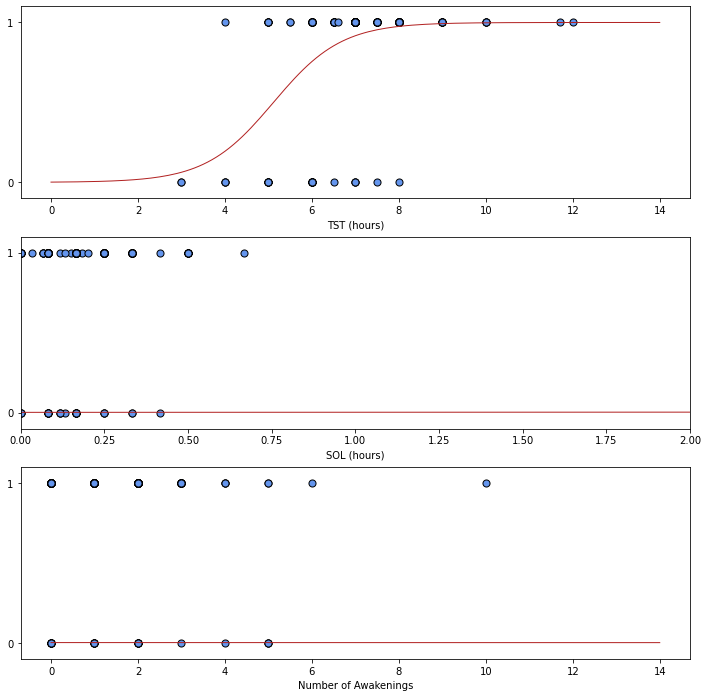

In [43]:
fig, axes = plt.subplots(3,1,figsize=(12,12))
xs = np.arange(0,14.1,0.1)
ys = {'full':[],'tst':[],'sol':[],'naw':[]}
for x_val in xs:
    ys['full'].append(1 / (1+math.exp(-1*(model.intercept_[0]+x_val*model.coef_[0][0]+x_val*model.coef_[0][1]+x_val*model.coef_[0][2]))))
    ys['tst'].append(1 / (1+math.exp(-1*(model.intercept_[0]+x_val*model.coef_[0][0]))))
    ys['sol'].append(1 / (1+math.exp(-1*(model.intercept_[0]+x_val*model.coef_[0][1]))))
    ys['naw'].append(1 / (1+math.exp(-1*(model.intercept_[0]+x_val*model.coef_[0][2]))))
    
ax = axes[0]
ax.scatter(x['TST'],y['score'],color='cornflowerblue',edgecolor='black',s=50,label='Raw Data Points')
ax.plot(xs,ys['tst'],color='firebrick',linewidth=1,label='TST Only')
ax.set_xlabel('TST (hours)')

ax = axes[1]
ax.scatter(x['SOL'],y['score'],color='cornflowerblue',edgecolor='black',s=50,label='Raw Data Points')
ax.plot(xs,ys['sol'],color='firebrick',linewidth=1,label='SOL Only')
ax.set_xlim([0,2])
ax.set_xlabel('SOL (hours)')

ax = axes[2]
ax.scatter(x['NAW'],y['score'],color='cornflowerblue',edgecolor='black',s=50,label='Raw Data Points')
ax.plot(xs,ys['naw'],color='firebrick',linewidth=1,label='NAW Only')
ax.set_xlabel('Number of Awakenings')

for ax in axes:
    ax.set_ylim([-0.1,1.1])
    ax.set_yticks([0,1])

plt.subplots_adjust(hspace=0.2)
plt.show()
plt.close()


#### TST Only
Since TST seems to be the greatest predictor, we can create a model that takes into account only this parameter.

In [47]:
# sklearn
model = LogisticRegression()
model.fit(x['TST'].values.reshape(-1, 1),y)

print(f'TST:', round(model.coef_[0][0],3))
print(f'Intercept: {round(model.intercept_[0],3)}')

TST: 1.284
Intercept: -6.555


In [46]:
# statsmodels
x_sm = sm.add_constant(x['TST'])
log_reg = sm.Logit(y, x_sm).fit(method='lbfgs')
log_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  score   No. Observations:                  178
Model:                          Logit   Df Residuals:                      176
Method:                           MLE   Df Model:                            1
Date:                Fri, 18 Dec 2020   Pseudo R-squ.:                  0.2888
Time:                        12:44:30   Log-Likelihood:                -52.642
converged:                       True   LL-Null:                       -74.017
Covariance Type:            nonrobust   LLR p-value:                 6.217e-11
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -7.0896      1.662     -4.267      0.000     -10.346      -3.833
TST            1.3703      0.265      5.170      0.000       0.851       1.890
==============================================================================
"""

Similar results to when we included the other sleep metrics.

### Binary Classification - Low and High Restful Scores
Now we look at only the extreme restfulness scores as those might be more reliable.

In [63]:
df = ff_sleep_survey_df[(ff_sleep_survey_df['Restful'] == 0.0)]
df = df.append(ff_sleep_survey_df[(ff_sleep_survey_df['Restful'] == 3.0)])
x = df[['TST','SOL','NAW']]
# rescaling SOL to hours
x['SOL'] /= 60
y = df[['Restful']]
y['score'] = np.where(y['Restful'] < 2, 0, 1)
y.drop(['Restful'],axis=1,inplace=True)

Fitting the model

In [66]:
# sklearn
model = LogisticRegression(solver='lbfgs')
model.fit(x,y)
for sleep_metric, c in zip(x.columns.values,model.coef_[0]):
    print(f'{sleep_metric}: {round(c,3)}')
    
print(f'Intercept: {round(model.intercept_[0],3)}')

TST: 1.223
SOL: 0.424
NAW: -0.399
Intercept: -5.501


In [68]:
# statsmodels
x_sm = sm.add_constant(x)
log_reg = sm.Logit(y, x_sm).fit(method='lbfgs')
log_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  score   No. Observations:                   68
Model:                          Logit   Df Residuals:                       64
Method:                           MLE   Df Model:                            3
Date:                Fri, 18 Dec 2020   Pseudo R-squ.:                  0.5461
Time:                        12:53:41   Log-Likelihood:                -9.2103
converged:                       True   LL-Null:                       -20.294
Covariance Type:            nonrobust   LLR p-value:                 6.023e-05
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -8.1197      3.745     -2.168      0.030     -15.460      -0.780
TST            1.4179      0.583      2.432      0.015       0.275       2.561
SOL           21.1175     10.850      1.946      0.052      -0.149      42.384
NAW           -1.2171      0.502     -2.426      0.015      -2.200      -0.234
==============================================================================
"""

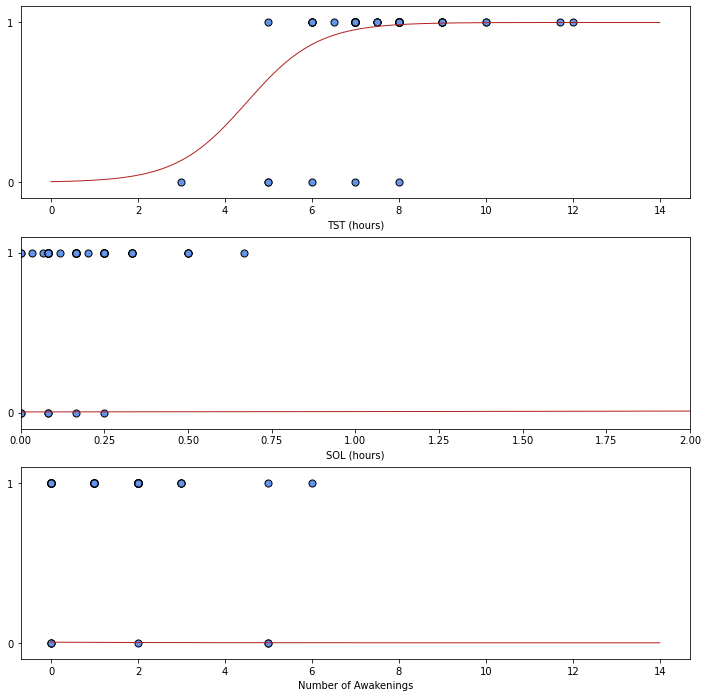

In [69]:
fig, axes = plt.subplots(3,1,figsize=(12,12))
xs = np.arange(0,14.1,0.1)
ys = {'full':[],'tst':[],'sol':[],'naw':[]}
for x_val in xs:
    ys['full'].append(1 / (1+math.exp(-1*(model.intercept_[0]+x_val*model.coef_[0][0]+x_val*model.coef_[0][1]+x_val*model.coef_[0][2]))))
    ys['tst'].append(1 / (1+math.exp(-1*(model.intercept_[0]+x_val*model.coef_[0][0]))))
    ys['sol'].append(1 / (1+math.exp(-1*(model.intercept_[0]+x_val*model.coef_[0][1]))))
    ys['naw'].append(1 / (1+math.exp(-1*(model.intercept_[0]+x_val*model.coef_[0][2]))))
    
ax = axes[0]
ax.scatter(x['TST'],y['score'],color='cornflowerblue',edgecolor='black',s=50,label='Raw Data Points')
ax.plot(xs,ys['tst'],color='firebrick',linewidth=1,label='TST Only')
ax.set_xlabel('TST (hours)')

ax = axes[1]
ax.scatter(x['SOL'],y['score'],color='cornflowerblue',edgecolor='black',s=50,label='Raw Data Points')
ax.plot(xs,ys['sol'],color='firebrick',linewidth=1,label='SOL Only')
ax.set_xlim([0,2])
ax.set_xlabel('SOL (hours)')

ax = axes[2]
ax.scatter(x['NAW'],y['score'],color='cornflowerblue',edgecolor='black',s=50,label='Raw Data Points')
ax.plot(xs,ys['naw'],color='firebrick',linewidth=1,label='NAW Only')
ax.set_xlabel('Number of Awakenings')

for ax in axes:
    ax.set_ylim([-0.1,1.1])
    ax.set_yticks([0,1])

plt.subplots_adjust(hspace=0.2)
plt.show()
plt.close()


<div class="alert alert-block alert-info">
    The TST seems to be the greatest predictor of restful even under this regime, but the relationship is weaker in this instance. This is unfortunate considering this scheme should produce more dramatic differences. 
<div>